# Recurrent neural network and dynamical system analysis

In this tutorial, we will use supervised learning to train a recurrent neural network on a simple perceptual decision making task, and analyze the trained network using dynamical system analysis.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gyyang/nn-brain/blob/master/RNN%2BDynamicalSystemAnalysis.ipynb)

## Install dependencies

## Defining a cognitive task

In [1]:
import numpy as np
import matplotlib.pyplot as plt


/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.h

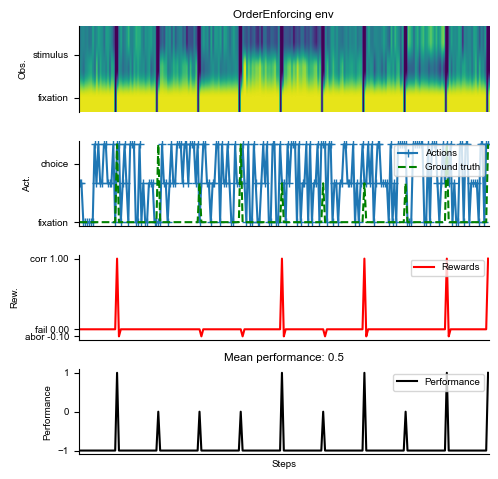

In [2]:
import neurogym as ngym

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 200

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=10)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

## Define a vanilla continuous-time recurrent network

Here we will define a continuous-time neural network but discretize it in time using the Euler method.
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [3]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

## Train the recurrent network on the decision-making task

In [142]:
import torch.optim as optim
import random
# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

running_loss = 0
training_losses = []
accuracies = []
accuracies_test = []

for i in range(1000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Forward pass and optimization
    optimizer.zero_grad()   # zero the gradient buffers
    output, _ = net(inputs)
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update
    
    # Store the loss for visualization
    training_losses.append(loss.item())
    
    # Calculate accuracy
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    accuracies.append(accuracy)

    inputs_test, labels_test = dataset()
    inputs_test = torch.from_numpy(inputs_test).type(torch.float)
    labels_test = torch.from_numpy(labels_test.flatten()).type(torch.long)

    # test the network the input_test and labels_test
    output_test, _ = net(inputs_test)
    output_test = output_test.view(-1, output_size)
    loss_test = criterion(output_test, labels_test)
    _, predicted_test = torch.max(output_test, 1)
    correct_test = (predicted_test == labels_test).sum().item()
    accuracy_test = correct_test / labels_test.size(0)
    accuracies_test.append(accuracy_test)    


    running_loss += loss.item()
    if i % 100 == 99:
        avg_accuracy = sum(accuracies[-100:]) / 100
        avg_accuracy_test = sum(accuracies_test[-100:]) / 100
        running_loss /= 100
        print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Accuracy test {:0.4f}'.format(i+1, running_loss, avg_accuracy, avg_accuracy_test))
        running_loss = 0


Step 100, Loss 0.3037, Accuracy 0.9582, Accuracy test 0.9589
Step 200, Loss 0.0372, Accuracy 0.9838, Accuracy test 0.9841
Step 300, Loss 0.0244, Accuracy 0.9890, Accuracy test 0.9895
Step 400, Loss 0.0164, Accuracy 0.9929, Accuracy test 0.9929
Step 500, Loss 0.0164, Accuracy 0.9930, Accuracy test 0.9931
Step 600, Loss 0.0136, Accuracy 0.9940, Accuracy test 0.9940
Step 700, Loss 0.0128, Accuracy 0.9943, Accuracy test 0.9942
Step 800, Loss 0.0121, Accuracy 0.9944, Accuracy test 0.9944
Step 900, Loss 0.0125, Accuracy 0.9942, Accuracy test 0.9944
Step 1000, Loss 0.0114, Accuracy 0.9945, Accuracy test 0.9944


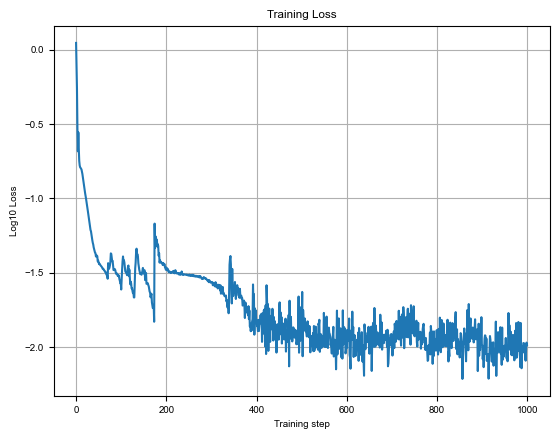

In [64]:
# Plot the training loss
plt.plot(np.log10(training_losses))
plt.xlabel('Training step')
plt.ylabel('Log10 Loss')
plt.title('Training Loss')
plt.grid()
plt.savefig('../training_loss.png')
plt.show()

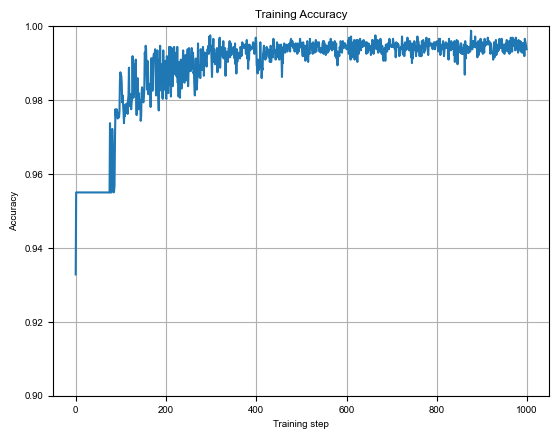

In [150]:
# plot the training accuracy
plt.plot(accuracies)
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid()
plt.ylim(0.9, 1.0)
plt.savefig('../training_accuracy.png')
plt.show()

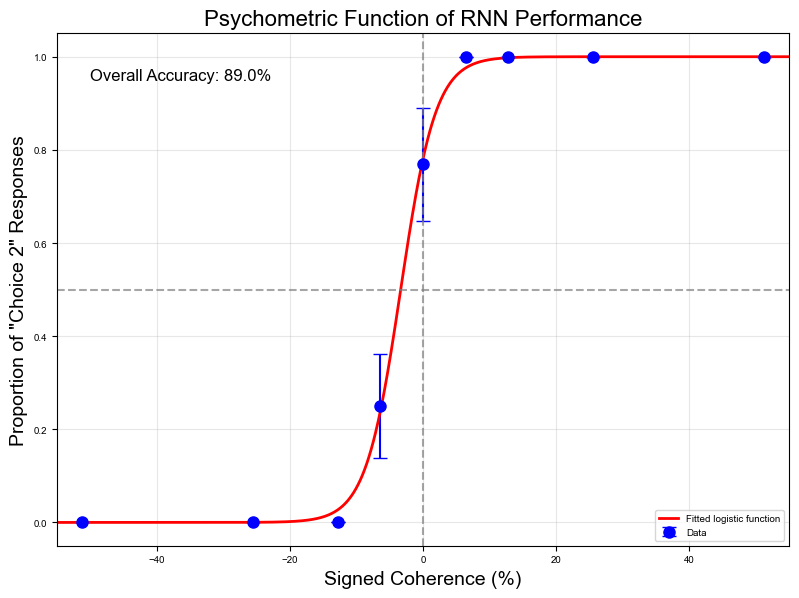

In [149]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Create a psychometric function plot showing network performance by coherence level

import matplotlib.pyplot as plt

# Convert trial_infos to a DataFrame if not already done
if 'df' not in locals():
    df = pd.DataFrame.from_dict(trial_infos, orient='index')

# Create a new column for signed coherence (negative for ground_truth=1, positive for ground_truth=2)
df['signed_coh'] = df.apply(lambda row: row['coh'] if row['ground_truth'] == 2 else -row['coh'], axis=1)

# Group by signed coherence and calculate proportion of choices
# For the psychometric function, we want to plot the proportion of "choice 2" responses
df['choice_2'] = df.apply(lambda row: int(not row['correct']) if row['ground_truth'] == 1 else int(row['correct']), axis=1)

# Group by signed coherence and calculate mean and SEM
grouped = df.groupby('signed_coh')['choice_2'].agg(['mean', 'count', 'std']).reset_index()
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# Create the plot
plt.figure(figsize=(8, 6))

# Plot data points with error bars
plt.errorbar(grouped['signed_coh'], grouped['mean'], yerr=grouped['sem'], 
             fmt='o', color='blue', markersize=8, capsize=5, label='Data')

# Add a smooth curve (logistic function)
# Fit a logistic regression model

def logistic(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Sort the data for fitting
sorted_indices = np.argsort(grouped['signed_coh'])
x_data = grouped['signed_coh'].values[sorted_indices]
y_data = grouped['mean'].values[sorted_indices]

# Fit the curve
try:
    popt, pcov = curve_fit(logistic, x_data, y_data)
    
    # Generate points for the smooth curve
    x_smooth = np.linspace(-55, 55, 1000)
    y_smooth = logistic(x_smooth, *popt)
    
    # Plot the fitted curve
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Fitted logistic function')
except:
    # If curve fitting fails, just connect the dots
    plt.plot(x_data, y_data, 'r--', linewidth=2, label='Connected data points')

# Add reference line at 0.5
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Formatting
plt.xlabel('Signed Coherence (%)', fontsize=14)
plt.ylabel('Proportion of "Choice 2" Responses', fontsize=14)
plt.title('Psychometric Function of RNN Performance', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

# Set axis limits
plt.xlim(-55, 55)
plt.ylim(-0.05, 1.05)

# Add text showing performance
accuracy = df['correct'].mean() * 100
plt.text(-50, 0.95, f'Overall Accuracy: {accuracy:.1f}%', fontsize=12)

plt.tight_layout()
plt.savefig('../psychometric_function.png', dpi=300)
plt.show()

## Visualize neural activity for in sample trials

We will run the network for 100 sample trials, then visual the neural activity trajectories in a PCA space.

In [65]:
import numpy as np
env.reset(no_step=True)
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    # print('Trial ', i, 'Ground truth: ', gt[-1])
    # print(env.trial)
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()

    action_pred = action_pred.detach().numpy()[:, 0, :]
    # print('Action prediction: ', action_pred[-1, :])
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    activity_dict[i] = rnn_activity
    trial_infos[i] = env.trial
    trial_infos[i].update({'correct': correct})
    trial_infos[i].update({'ground_truth': gt[-1]})

    
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)
print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

# Print trial informations
for i in range(5):
    print('Trial ', i, trial_infos[i])

Shape of the neural activity: (Time points, Neurons):  (2200, 64)
Average performance 0.89
Trial  0 {'ground_truth': 1, 'coh': 0.0, 'correct': True}
Trial  1 {'ground_truth': 1, 'coh': 25.6, 'correct': True}
Trial  2 {'ground_truth': 1, 'coh': 6.4, 'correct': True}
Trial  3 {'ground_truth': 1, 'coh': 51.2, 'correct': True}
Trial  4 {'ground_truth': 2, 'coh': 51.2, 'correct': True}


In [151]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

PCA(n_components=3)

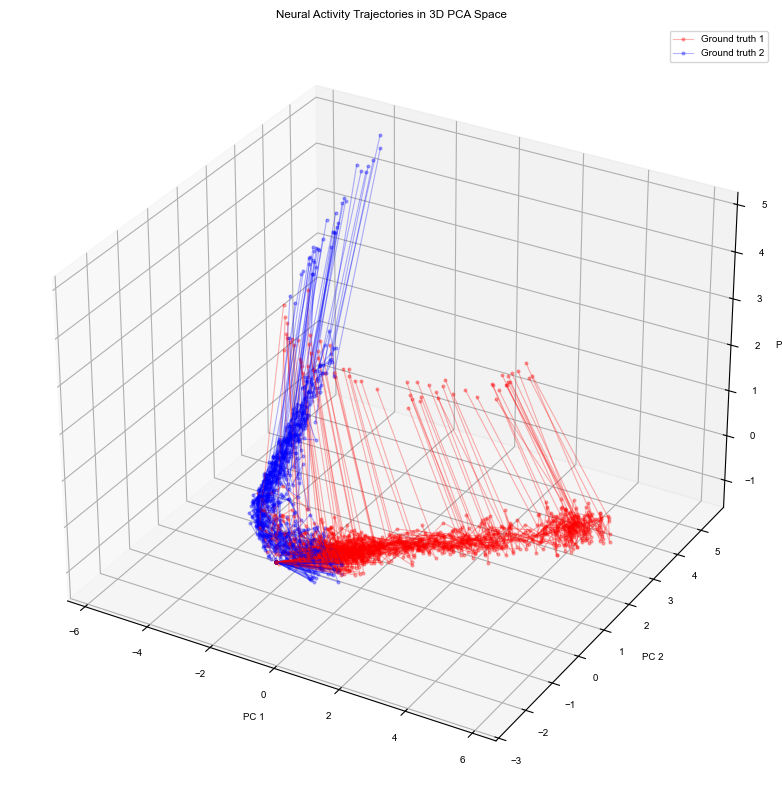

In [152]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D PCA plot colored by ground truth

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot neural activity trajectories in 3D PC space
legend_labels = set()
for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    label = 'Ground truth 1' if trial['ground_truth'] == 1 else 'Ground truth 2'
    
    # Only add label if not already in legend
    if label not in legend_labels:
        legend_labels.add(label)
        ax.plot(activity_pc[:, 0], activity_pc[:, 1], activity_pc[:, 2], 
                'o-', color=color, alpha=0.3, markersize=2, linewidth=0.8, label=label)
    else:
        ax.plot(activity_pc[:, 0], activity_pc[:, 1], activity_pc[:, 2], 
                'o-', color=color, alpha=0.3, markersize=2, linewidth=0.8)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Neural Activity Trajectories in 3D PCA Space')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

Transform individual trials and Visualize in PC space based on ground-truth color. We see that the neural activity is organized by stimulus ground-truth in PC1

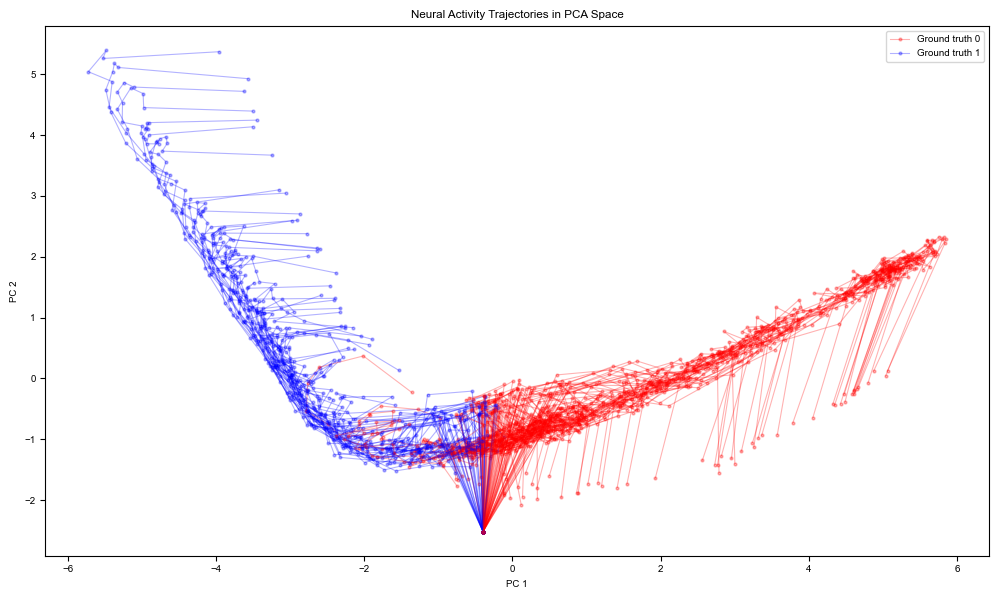

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot neural activity trajectories in PC space
legend_labels = set()
for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    label = 'Ground truth 0' if trial['ground_truth'] == 1 else 'Ground truth 1'
    
    # Only add label if not already in legend
    if label not in legend_labels:
        legend_labels.add(label)
        ax.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.3, 
                markersize=2, linewidth=0.8, label=label)
    else:
        ax.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.3, 
                markersize=2, linewidth=0.8)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('Neural Activity Trajectories in PCA Space')

# Add legend
ax.legend()

plt.tight_layout()
# plt.savefig('../pca_trajectory.png', dpi=300)
plt.show()

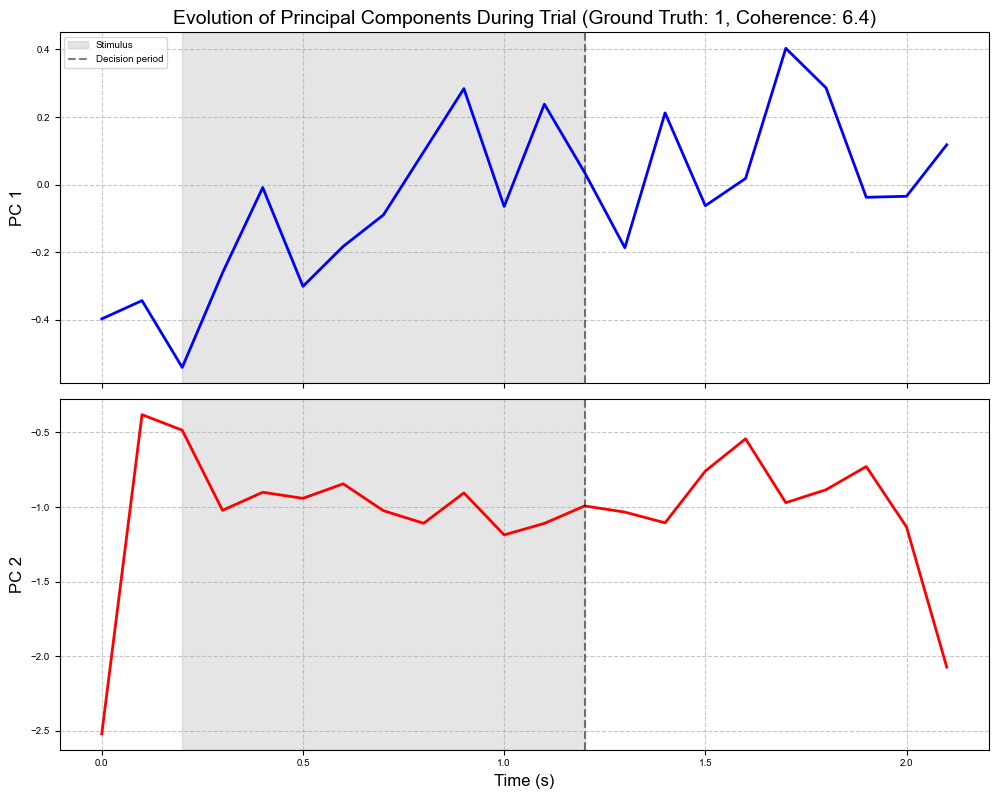

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Select a specific trial to visualize
trial_idx = 2  # Choose the first trial
activity_trial = activity_dict[trial_idx]
trial_info = trial_infos[trial_idx]

# Project the activity onto PC space
activity_pc = pca.transform(activity_trial)

# Extract PC1 and PC2 trajectories
pc1_trajectory = activity_pc[:, 0]
pc2_trajectory = activity_pc[:, 1]

# Create time steps for x-axis (assuming dt=100ms from the environment)
time_steps_trial = np.arange(0, len(pc1_trajectory) * 0.1, 0.1)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot PC1 over time
axs[0].plot(time_steps_trial, pc1_trajectory, 'b-', linewidth=2)
axs[0].set_ylabel('PC 1', fontsize=12)
axs[0].set_title(f'Evolution of Principal Components During Trial (Ground Truth: {trial_info["ground_truth"]}, Coherence: {trial_info["coh"]})', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot PC2 over time
axs[1].plot(time_steps_trial, pc2_trajectory, 'r-', linewidth=2)
axs[1].set_ylabel('PC 2', fontsize=12)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Add vertical lines to mark important periods
# Assuming first 0.2s is fixation, next 1.0s is stimulus, and rest is decision
for ax in axs:
    ax.axvspan(0.2, 1.2, color='gray', alpha=0.2, label='Stimulus')
    ax.axvline(1.2, color='k', linestyle='--', alpha=0.5, label='Decision period')

# Add legend to the first subplot
axs[0].legend(loc='upper left')

plt.tight_layout()
plt.show()

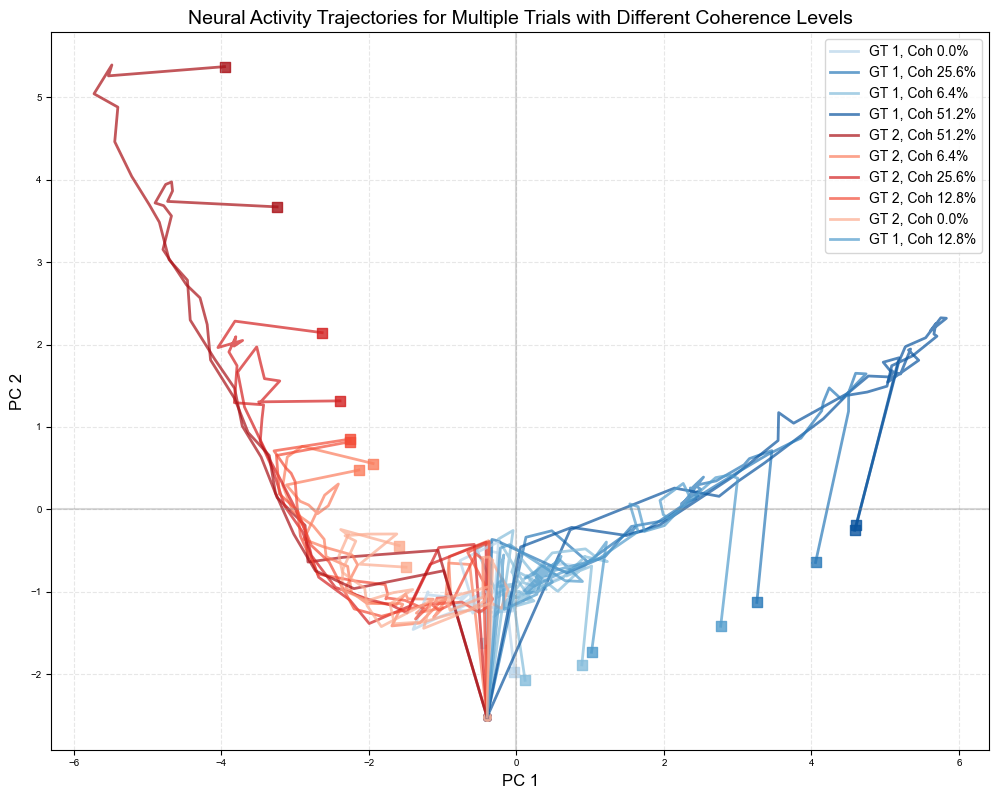

In [135]:
# Create a figure to visualize multiple trials with different coherence levels
fig, ax = plt.subplots(figsize=(10, 8))

# Define a color scheme based on ground truth and coherence
cmap_gt0 = plt.cm.Blues
cmap_gt1 = plt.cm.Reds

# Select a few representative trials with different coherence levels
coherence_levels = [0.0, 6.4, 12.8, 25.6, 51.2]

# Counter to limit the number of trials per condition
max_trials_per_condition = 2
trial_counts = {(gt, coh): 0 for gt in [1, 2] for coh in coherence_levels}

# Plot the trajectories
for i in range(num_trial):
    trial_info = trial_infos[i]
    gt = trial_info['ground_truth']
    coh = trial_info['coh']
    
    # Skip if we've already plotted enough trials of this condition
    if trial_counts[(gt, coh)] >= max_trials_per_condition:
        continue
    
    # Increment counter
    trial_counts[(gt, coh)] += 1
    
    # Project the activity onto PC space
    activity_pc = pca.transform(activity_dict[i])
    
    # Choose color based on ground truth and coherence
    if gt == 1:
        color = cmap_gt0(0.3 + 0.7 * coherence_levels.index(coh) / len(coherence_levels))
        label = f"GT 1, Coh {coh}%"
    else:  # gt == 2
        color = cmap_gt1(0.3 + 0.7 * coherence_levels.index(coh) / len(coherence_levels))
        label = f"GT 2, Coh {coh}%"
    
    # Plot trajectory
    ax.plot(activity_pc[:, 0], activity_pc[:, 1], '-', color=color, linewidth=2, alpha=0.7, label=label)
    
    # Mark start and end points
    ax.scatter(activity_pc[0, 0], activity_pc[0, 1], color=color, s=30, marker='o', alpha=0.8)
    ax.scatter(activity_pc[-1, 0], activity_pc[-1, 1], color=color, s=60, marker='s', alpha=0.8)

# Add labels and title
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)
ax.set_title('Neural Activity Trajectories for Multiple Trials with Different Coherence Levels', fontsize=14)

# Add grid
ax.grid(True, linestyle='--', alpha=0.3)

# Add legend with only unique labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

# Add vertical and horizontal zero lines for reference
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## Dynamical system analysis

### Search for approximate fixed points
Here we search for approximate fixed points and visualize them in the same PC space. In a generic dynamical system,
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
We can search for fixed points by doing the optimization
\begin{align}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [136]:
# Freeze for parameters in the recurrent network
for param in net.parameters():
    param.requires_grad = False

batch_size = 128

# Inputs should be the 0-coherence mean input during stimulus period
# This will be task-specific
input = np.tile([1, 0.5, 0.5], (batch_size, 1))
input = torch.tensor(input, dtype=torch.float32)

# Here hidden activity is the variable to be optimized
# Initialized randomly for search in parallel (activity all positive)
hidden = torch.tensor(np.random.rand(batch_size, hidden_size)*3,
                      requires_grad=True, dtype=torch.float32)

# Use Adam optimizer
optimizer = optim.Adam([hidden], lr=0.001)
criterion = nn.MSELoss()

running_loss = 0
for i in range(12000):
    optimizer.zero_grad()   # zero the gradient buffers
    
    # Take the one-step recurrent function from the trained network
    new_h = net.rnn.recurrence(input, hidden)
    loss = criterion(new_h, hidden)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 1000 == 999:
        running_loss /= 1000
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Step 1000, Loss 2.6090
Step 2000, Loss 0.7535
Step 3000, Loss 0.2399
Step 4000, Loss 0.0720
Step 5000, Loss 0.0196
Step 6000, Loss 0.0049
Step 7000, Loss 0.0012
Step 8000, Loss 0.0003
Step 9000, Loss 0.0001
Step 10000, Loss 0.0001
Step 11000, Loss 0.0001
Step 12000, Loss 0.0000


### Visualize the found approximate fixed points.

We see that they found an approximate line attrator, corresponding to our PC1, along which evidence is integrated during the stimulus period.

(128, 64)


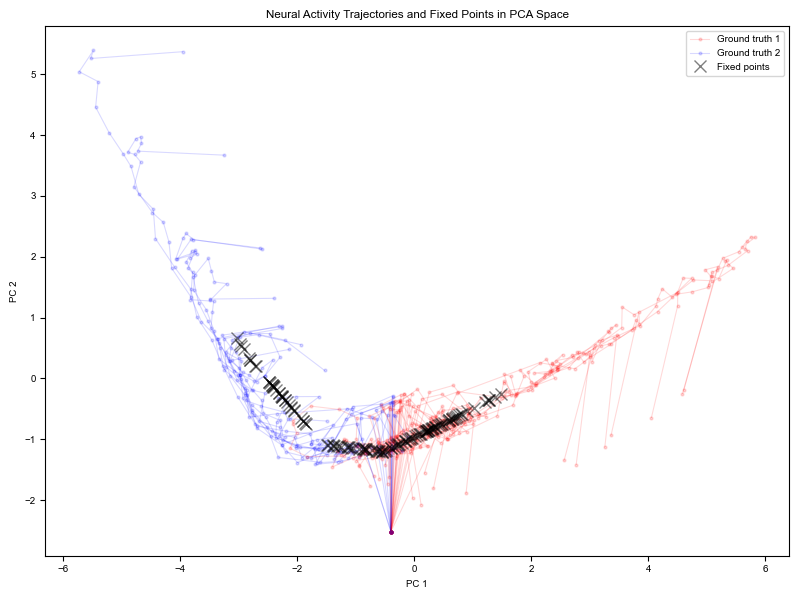

In [161]:
fixedpoints = hidden.detach().numpy()
print(fixedpoints.shape)

# Plot in the same space as activity
plt.figure(figsize=(8, 6))

# Track which labels we've added to avoid duplicates
labels_added = set()

for i in range(30):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    
    # Create consistent labels
    if trial['ground_truth'] == 1:
        label = 'Ground truth 1'
    else:
        label = 'Ground truth 2'
    
    # Only add label if we haven't seen this label before
    if label not in labels_added:
        labels_added.add(label)
        plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
                 color=color, alpha=0.15, markersize=2, linewidth=0.8,
                 label=label)
    else:
        plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
                 color=color, alpha=0.15, markersize=2, linewidth=0.8)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', markersize=8, 
         color='black', alpha=0.5, label='Fixed points')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Neural Activity Trajectories and Fixed Points in PCA Space')
plt.legend()
plt.savefig('../pca_fixedpoints.png', dpi=300)
plt.tight_layout()
plt.show()

### Computing the Jacobian and finding the line attractor

First we will compute the Jacobian.

In [162]:
# index of fixed point to focus on
# choose one close to center by sorting PC1
i_fp = np.argsort(fixedpoints[:, 0])[int(fixedpoints.shape[0]/2)]

fp = torch.from_numpy(fixedpoints[i_fp])
fp.requires_grad = True

# Inputs should be the 0-coherence mean input during stimulus period
# This will be task-specific
input = torch.tensor([1, 0.5, 0.5], dtype=torch.float32)
deltah = net.rnn.recurrence(input, fp) - fp

# w1 = torch.randn((64,64), requires_grad = False)                                                                                         
# new_h = w1@fp

jacT = torch.zeros(hidden_size, hidden_size)
for i in range(hidden_size):                                                                                                                     
    output = torch.zeros(hidden_size)                                                                                                          
    output[i] = 1.                                                                                                                     
    jacT[:,i] = torch.autograd.grad(deltah, fp, grad_outputs=output, retain_graph=True)[0]
    
jac = jacT.detach().numpy().T

Here we plot the direction of the eigenvector corresponding to the highest eigenvalue

Text(0, 0.5, 'PC 2')

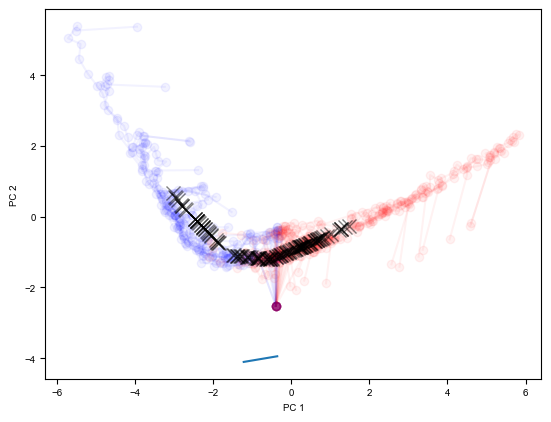

In [163]:
eigval, eigvec = np.linalg.eig(jac)
vec1 = np.real(eigvec[:, 0])
end_pts = np.array([+vec1, -vec1]) * 3
end_pts = pca.transform(end_pts)


# Plot in the same space as activity
plt.figure()
for i in range(30):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
             color=color, alpha=0.05)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', markersize=10, alpha=0.5, color='black')

# Line attractor
plt.plot(end_pts[:, 0], end_pts[:, 1])
# plt.plot(end_pts_2[:, 0], end_pts_2[:, 1], '--')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [165]:
len(eigval)

64

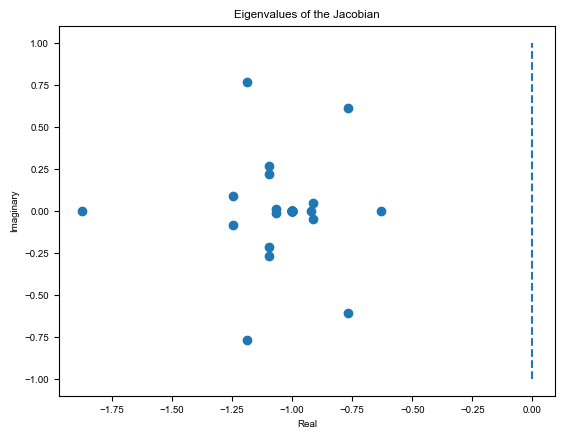

In [167]:
# Plot distribution of eigenvalues in a 2-d real-imaginary plot
plt.figure()
plt.scatter(np.real(eigval), np.imag(eigval))
plt.plot([0, 0], [-1, 1], '--')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Eigenvalues of the Jacobian')
# plt.grid()
plt.savefig('../eigenvalues_jacobian.png', dpi=300)

# Supplementary Materials

Code for making publication quality figures as it appears in the paper.

In [166]:
# Convert information into pandas dataframe
import pandas as pd

# Create a DataFrame from the trial_infos dictionary
df = pd.DataFrame.from_dict(trial_infos, orient='index')

# Example selection of conditions
print(df[(df['coh']==6.4) & (df['ground_truth']==1.0)])

    ground_truth  coh  correct
2              1  6.4     True
5              1  6.4     True
13             1  6.4     True
17             1  6.4    False
19             1  6.4    False
20             1  6.4     True
29             1  6.4    False
36             1  6.4     True
38             1  6.4     True
40             1  6.4     True
47             1  6.4     True
48             1  6.4    False
53             1  6.4     True
55             1  6.4     True
77             1  6.4     True
88             1  6.4     True


FileNotFoundError: [Errno 2] No such file or directory: 'figures/rnndynamics_dm.pdf'

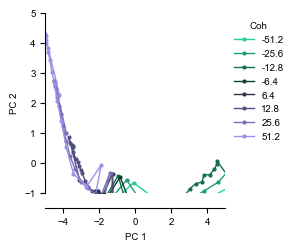

In [40]:
plot_fp = False

# Plot in the same space as activity
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])

colors = np.array([[27,158,119], [117,112,179], [217,95,2]])/255.

# Search for two trials with similar conditions
cohs = np.unique(df['coh'])
cohs = [c for c in cohs if c > 0]  # remove 0

color_intensity = [0.4, 0.7, 1.0, 1.3]

for ground_truth in [0, 1]:
    if ground_truth == 0:
        cohs_ = cohs[::-1]
        color_intensity_ = color_intensity[::-1]
    else:
        cohs_ = cohs
        color_intensity_ = color_intensity
    for i_coh, coh in enumerate(cohs_):
        if plot_fp and coh != cohs[2]:
            continue
        trials = df[(df['coh']==coh) & (df['ground_truth']==ground_truth)].index
        activity = np.mean(np.array([activity_dict[i] for i in trials]), axis=0)

        activity_pc = pca.transform(activity)
        color = colors[0] if ground_truth == 0 else colors[1]
        color = color * color_intensity_[i_coh]
        signed_coh = coh * (2*ground_truth - 1)
        label = '{:0.1f}'.format(signed_coh)
        plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
                 color=color, ms=3, markeredgecolor='none',
                 lw=1, label=label)


if plot_fp:
    # Fixed points are shown in cross
    color = colors[2]
    fixedpoints_pc = pca.transform(fixedpoints)
    plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', ms=3, color=color, alpha=0.3)

    # Line attractor
    plt.plot(fixedpoints_pc[i_fp, 0], fixedpoints_pc[i_fp, 1], 'x', ms=5, color=color, lw=1)
    plt.plot(end_pts[:, 0], end_pts[:, 1], color=color)
else:
    ax.legend(title='Coh', loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)


plt.xlabel('PC 1', fontsize=7)
plt.ylabel('PC 2', fontsize=7)

plt.xlim([-5, 5])
plt.ylim([-1, 5])

# Beautification
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('data', -5))
ax.spines['bottom'].set_position(('data', -1.5))

from pathlib import Path
if plot_fp:
    fname = Path('figures/lineattractors_dm')
else:
    fname = Path('figures/rnndynamics_dm')
fig.savefig(fname.with_suffix('.pdf'), transparent=True)
fig.savefig(fname.with_suffix('.png'), dpi=300)